# Employee Attrition Prediction
**IBM HR Analytics Dataset**

---

**Project:** Devsil Phase 1 — Project 7  
**Role:** Junior Data Scientist, HR Analytics  
**Objective:** Predict which employees are likely to leave and identify the key drivers behind attrition.

---

**Notebook structure**

1. Environment setup and data loading  
2. Data cleaning and preprocessing  
3. Exploratory data analysis  
4. Statistical analysis and hypothesis testing  
5. Feature engineering  
6. Model training and comparison  
7. Model evaluation and selection  
8. Business insights and recommendations

---
## 1. Environment Setup

In [7]:
# Install missing dependency for SMOTE
%pip install -q imbalanced-learn

import warnings
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

from scipy import stats
from scipy.stats import ttest_ind, chi2_contingency
from statsmodels.stats.proportion import proportion_confint

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve,
    classification_report, ConfusionMatrixDisplay
)

from imblearn.over_sampling import SMOTE
import joblib

# ── Config ──────────────────────────────────────────────────────────────────
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

sns.set_theme(style='whitegrid', palette='muted', font_scale=1.1)
COLORS = {'No': '#4C8BE0', 'Yes': '#E05C4C'}  # blue = stayed, red = left

print('Python:', sys.version.split()[0])
print('pandas:', pd.__version__, '| numpy:', np.__version__)

Note: you may need to restart the kernel to use updated packages.
Python: 3.14.1
pandas: 2.3.3 | numpy: 2.3.5


In [8]:
# ── Load Data ───────────────────────────────────────────────────────────────


df_raw = pd.read_csv('HR_Employee_Attrition.csv')
print(f'Dataset shape: {df_raw.shape}')
df_raw.head()

Dataset shape: (1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,42,No,Travel_Frequently,1053,Research & Development,1,2,Medical,1,1,1,Female,44,4,1,Manufacturing Director,2,Married,3830,14878,0,Y,No,11,3,1,80,0,2,4,1,2,1,0,2
1,23,No,Non-Travel,1235,Human Resources,9,4,Life Sciences,1,2,4,Male,79,4,2,Manager,3,Single,4744,10420,0,Y,No,11,3,3,80,0,9,3,2,0,0,0,0
2,46,Yes,Travel_Rarely,1008,Research & Development,7,3,Life Sciences,1,3,3,Female,30,1,1,Healthcare Representative,1,Married,2969,8306,1,Y,No,11,3,2,80,2,10,4,3,10,5,1,0
3,28,Yes,Travel_Frequently,443,Research & Development,7,2,Life Sciences,1,4,3,Male,80,2,4,Laboratory Technician,1,Married,9631,12531,2,Y,No,16,3,3,80,0,4,4,3,4,4,2,2
4,33,No,Travel_Frequently,929,Sales,3,4,Life Sciences,1,5,1,Male,63,3,2,Sales Executive,4,Single,4857,9054,1,Y,No,11,3,4,80,1,25,2,4,0,0,0,0


---
## 2. Data Cleaning and Preprocessing

The raw file is never modified. All transformations are applied to a working copy. Every decision made here is documented inline.

In [9]:
df = df_raw.copy()

# ── 2.1 Missing values ──────────────────────────────────────────────────────
missing = df.isnull().sum()
missing = missing[missing > 0]
if missing.empty:
    print('No missing values.')
else:
    print(missing)

# ── 2.2 Duplicates ──────────────────────────────────────────────────────────
dupes = df.duplicated().sum()
print(f'Duplicate rows: {dupes}')
if dupes > 0:
    df.drop_duplicates(inplace=True)

# ── 2.3 Constant columns (zero variance — no predictive value) ───────────────
# EmployeeCount, StandardHours, Over18 are constant in this dataset.
const_cols = [col for col in df.columns if df[col].nunique() == 1]
print(f'Constant columns removed: {const_cols}')
df.drop(columns=const_cols, inplace=True)

# ── 2.4 Target variable ──────────────────────────────────────────────────────
df['Attrition_Binary'] = (df['Attrition'] == 'Yes').astype(int)
print(f'\nAttrition distribution:')
print(df['Attrition'].value_counts())
print(f'Overall attrition rate: {df["Attrition_Binary"].mean():.1%}')

No missing values.
Duplicate rows: 0
Constant columns removed: ['EmployeeCount', 'Over18', 'StandardHours']

Attrition distribution:
Attrition
No     1218
Yes     252
Name: count, dtype: int64
Overall attrition rate: 17.1%


In [10]:
# ── 2.5 Outlier detection (IQR method) ──────────────────────────────────────
# We flag outliers but retain them. In HR data, extreme values often carry
# legitimate signal (e.g., unusually high income, very long tenure).

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != 'Attrition_Binary']

outlier_report = {}
for col in numeric_cols:
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    n = ((df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)).sum()
    if n > 0:
        outlier_report[col] = {'count': n, 'pct': round(n / len(df) * 100, 2)}

out_df = pd.DataFrame(outlier_report).T.sort_values('count', ascending=False)
print('Outlier summary (flagged, not removed):')
print(out_df.head(10))

Outlier summary (flagged, not removed):
                           count     pct
PerformanceRating       214.0000 14.5600
TrainingTimesLastYear   206.0000 14.0100
StockOptionLevel        134.0000  9.1200
YearsSinceLastPromotion  32.0000  2.1800
YearsAtCompany            6.0000  0.4100
PercentSalaryHike         4.0000  0.2700
YearsWithCurrManager      2.0000  0.1400
MonthlyIncome             1.0000  0.0700
TotalWorkingYears         1.0000  0.0700
YearsInCurrentRole        1.0000  0.0700


In [11]:
# ── 2.6 Encoding ─────────────────────────────────────────────────────────────
# Binary → LabelEncoder. Nominal multi-class → get_dummies (one-hot).
# We preserve the original df for EDA and only encode in df_encoded.

df_encoded = df.copy()

le = LabelEncoder()
for col in ['Gender', 'OverTime']:
    df_encoded[col] = le.fit_transform(df_encoded[col])

cat_cols = [c for c in df_encoded.select_dtypes(include='object').columns
            if c != 'Attrition']
df_encoded = pd.get_dummies(df_encoded, columns=cat_cols, drop_first=True)

print(f'Encoded feature matrix: {df_encoded.shape}')

Encoded feature matrix: (1470, 47)


---
## 3. Exploratory Data Analysis

Each chart is designed to answer a specific question about attrition. We are not just plotting distributions — we are building hypotheses that will guide model design.

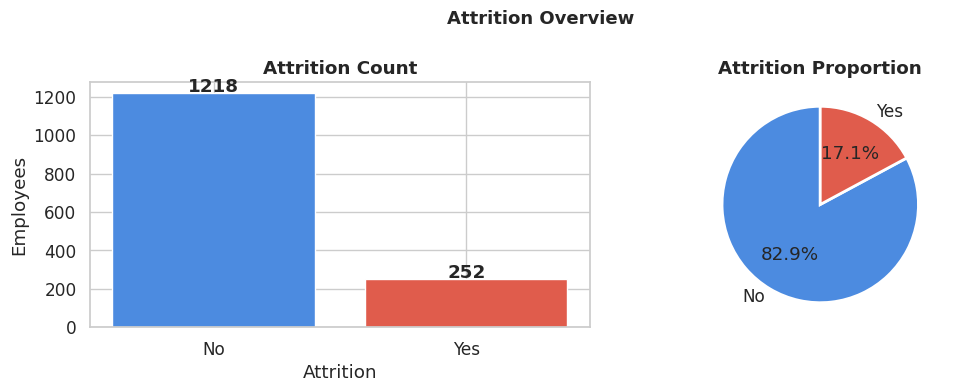

Class imbalance: 17.1% attrition rate.
SMOTE will be applied before training to address this.


In [12]:
# ── 3.1 Attrition distribution ───────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(11, 4))

counts = df['Attrition'].value_counts()
axes[0].bar(counts.index, counts.values,
            color=[COLORS[x] for x in counts.index], edgecolor='white')
for i, (k, v) in enumerate(counts.items()):
    axes[0].text(i, v + 8, str(v), ha='center', fontweight='bold')
axes[0].set_title('Attrition Count', fontweight='bold')
axes[0].set_xlabel('Attrition')
axes[0].set_ylabel('Employees')

axes[1].pie(counts.values, labels=counts.index, autopct='%1.1f%%',
            colors=[COLORS[x] for x in counts.index],
            startangle=90, wedgeprops={'edgecolor': 'white', 'linewidth': 2})
axes[1].set_title('Attrition Proportion', fontweight='bold')

plt.suptitle('Attrition Overview', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('fig_01_attrition_overview.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'Class imbalance: {counts["Yes"] / len(df):.1%} attrition rate.')
print('SMOTE will be applied before training to address this.')

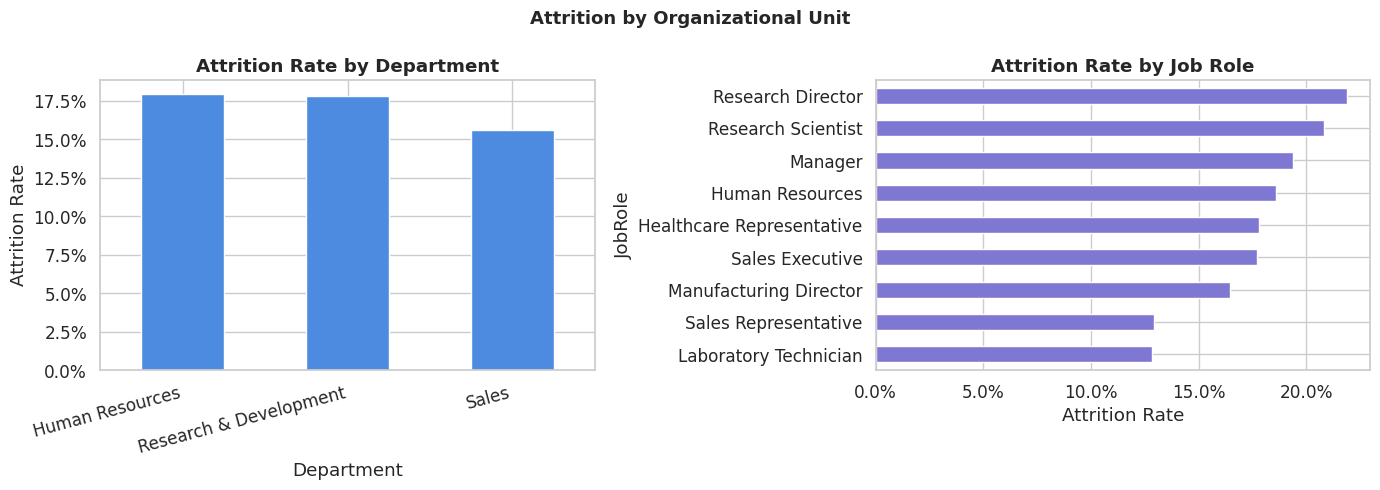

In [13]:
# ── 3.2 Department and Job Role ──────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

dept_rate = df.groupby('Department')['Attrition_Binary'].mean().sort_values(ascending=False)
dept_rate.plot(kind='bar', ax=axes[0], color='#4C8BE0', edgecolor='white')
axes[0].set_title('Attrition Rate by Department', fontweight='bold')
axes[0].set_ylabel('Attrition Rate')
axes[0].yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=15, ha='right')

role_rate = df.groupby('JobRole')['Attrition_Binary'].mean().sort_values()
role_rate.plot(kind='barh', ax=axes[1], color='#7E78D2', edgecolor='white')
axes[1].set_title('Attrition Rate by Job Role', fontweight='bold')
axes[1].set_xlabel('Attrition Rate')
axes[1].xaxis.set_major_formatter(mticker.PercentFormatter(1.0))

plt.suptitle('Attrition by Organizational Unit', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('fig_02_department_role.png', dpi=150, bbox_inches='tight')
plt.show()

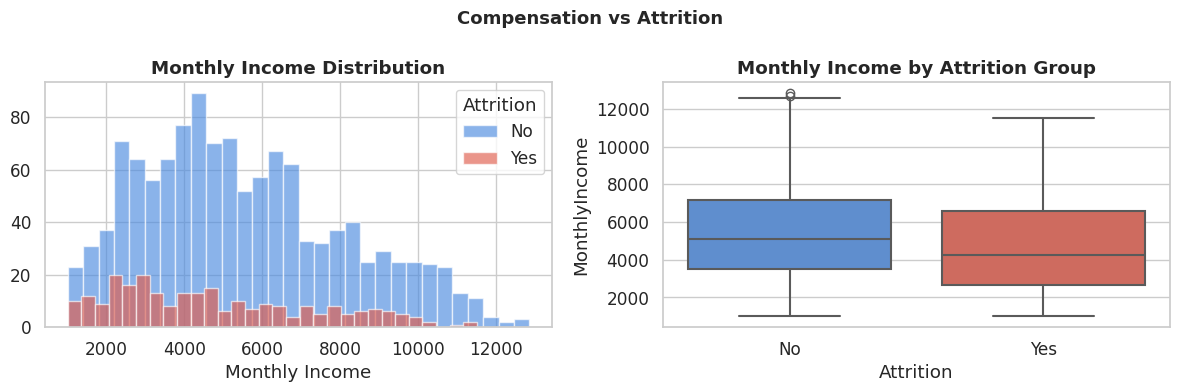

               mean    median       std
Attrition                              
No        5510.0000 5119.0000 2588.0000
Yes       4802.0000 4266.0000 2579.0000


In [14]:
# ── 3.3 Compensation ─────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for label, grp in df.groupby('Attrition'):
    axes[0].hist(grp['MonthlyIncome'], bins=30, alpha=0.65,
                 label=label, color=COLORS[label])
axes[0].set_title('Monthly Income Distribution', fontweight='bold')
axes[0].set_xlabel('Monthly Income')
axes[0].legend(title='Attrition')

sns.boxplot(data=df, x='Attrition', y='MonthlyIncome',
            palette=COLORS, ax=axes[1], linewidth=1.5)
axes[1].set_title('Monthly Income by Attrition Group', fontweight='bold')

plt.suptitle('Compensation vs Attrition', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('fig_03_income.png', dpi=150, bbox_inches='tight')
plt.show()

print(df.groupby('Attrition')['MonthlyIncome'].agg(['mean', 'median', 'std']).round(0))

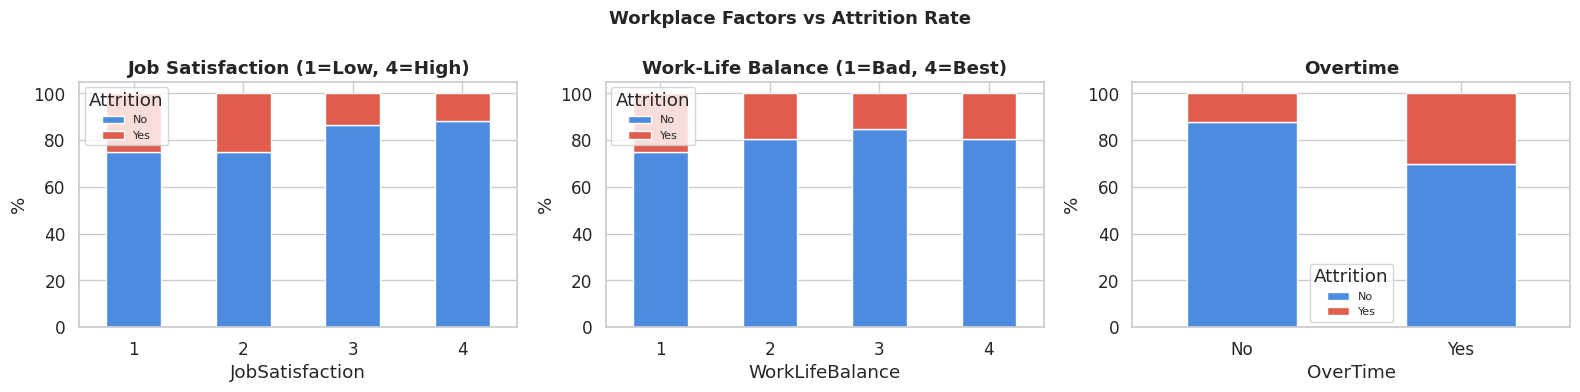

In [15]:
# ── 3.4 Workplace factors: Satisfaction, Work-Life Balance, Overtime ─────────
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for ax, col, title in zip(
    axes,
    ['JobSatisfaction', 'WorkLifeBalance', 'OverTime'],
    ['Job Satisfaction (1=Low, 4=High)',
     'Work-Life Balance (1=Bad, 4=Best)',
     'Overtime']
):
    ct = pd.crosstab(df[col], df['Attrition'], normalize='index') * 100
    ct.plot(kind='bar', ax=ax, color=[COLORS['No'], COLORS['Yes']],
            edgecolor='white', stacked=True)
    ax.set_title(title, fontweight='bold')
    ax.set_ylabel('%')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.legend(title='Attrition', fontsize=8)

plt.suptitle('Workplace Factors vs Attrition Rate', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('fig_04_workplace_factors.png', dpi=150, bbox_inches='tight')
plt.show()

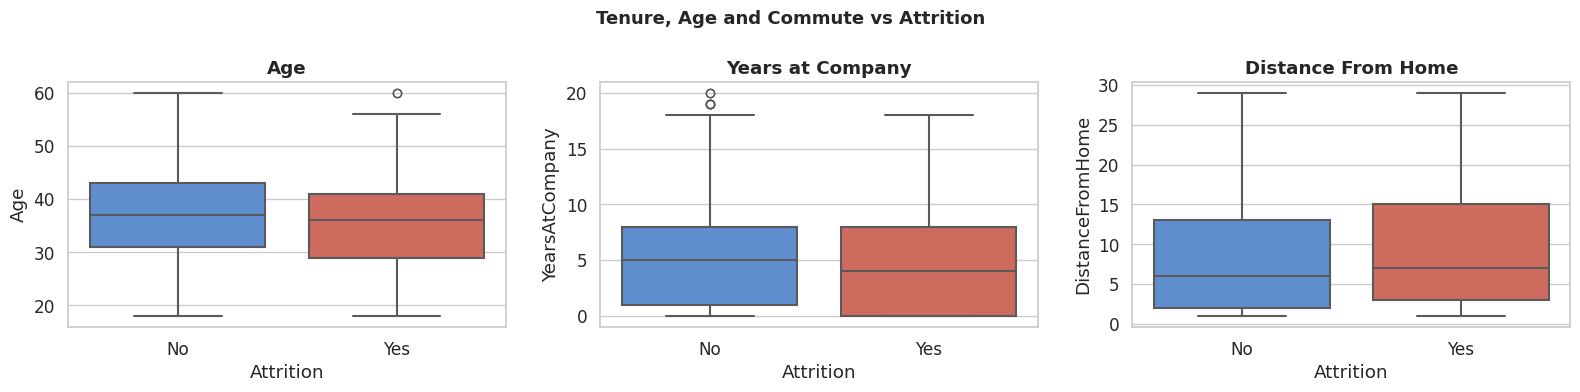

In [16]:
# ── 3.5 Tenure and age ───────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for ax, col, title in zip(
    axes,
    ['Age', 'YearsAtCompany', 'DistanceFromHome'],
    ['Age', 'Years at Company', 'Distance From Home']
):
    sns.boxplot(data=df, x='Attrition', y=col, palette=COLORS, ax=ax, linewidth=1.5)
    ax.set_title(title, fontweight='bold')

plt.suptitle('Tenure, Age and Commute vs Attrition', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('fig_05_tenure_age.png', dpi=150, bbox_inches='tight')
plt.show()

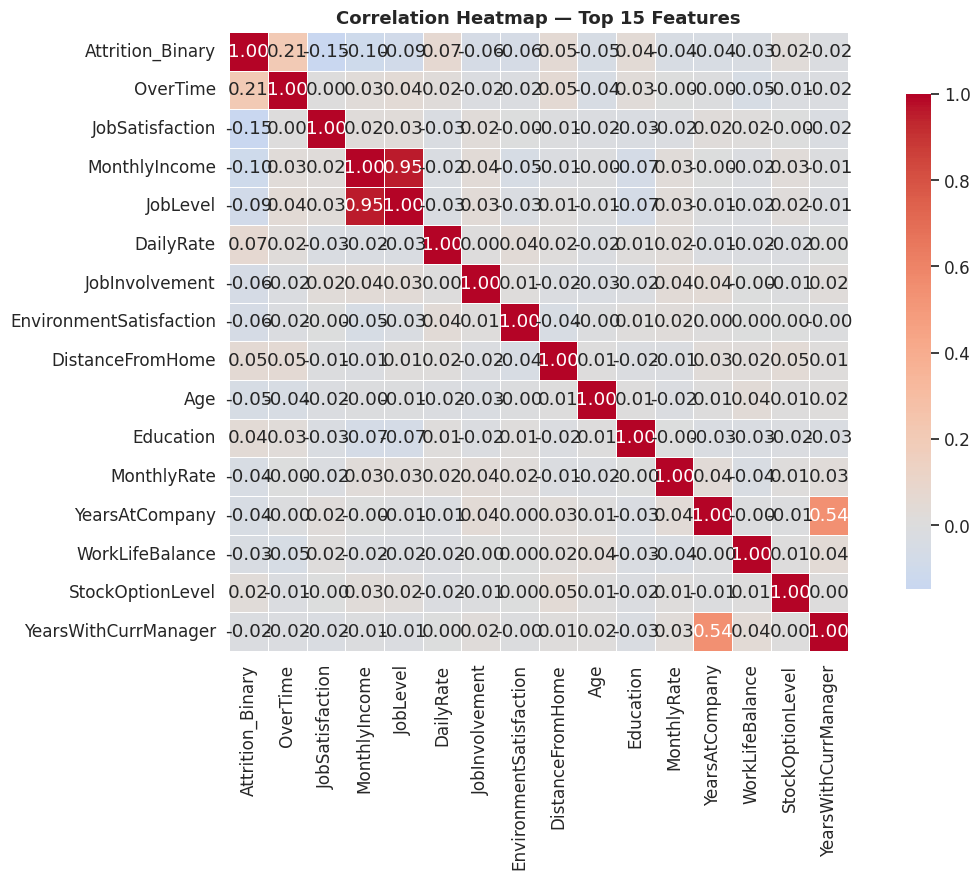

Top 10 features correlated with attrition:
OverTime                  0.2090
JobSatisfaction           0.1470
MonthlyIncome             0.1030
JobLevel                  0.0890
DailyRate                 0.0670
JobInvolvement            0.0610
EnvironmentSatisfaction   0.0570
DistanceFromHome          0.0500
Age                       0.0460
Education                 0.0450
Name: Attrition_Binary, dtype: float64


In [17]:
# ── 3.6 Correlation heatmap (top features with target) ───────────────────────
corr = df_encoded.select_dtypes(include=[np.number]).corr()
target_corr = corr['Attrition_Binary'].abs().sort_values(ascending=False)
top_feats = target_corr.head(16).index.tolist()

plt.figure(figsize=(13, 9))
sns.heatmap(
    corr.loc[top_feats, top_feats],
    annot=True, fmt='.2f', cmap='coolwarm',
    center=0, linewidths=0.4, square=True,
    cbar_kws={'shrink': 0.8}
)
plt.title('Correlation Heatmap — Top 15 Features', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('fig_06_correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print('Top 10 features correlated with attrition:')
print(target_corr.drop('Attrition_Binary').head(10).round(3))

---
## 4. Statistical Analysis and Hypothesis Testing

Visual patterns observed in EDA are now tested formally. Two-sample t-tests assess continuous variables; chi-square tests assess categorical associations. All tests use alpha = 0.05.

In [18]:
# ── 4.1 Descriptive statistics ───────────────────────────────────────────────
desc = df.describe(include=[np.number]).T
desc['cv'] = (desc['std'] / desc['mean']).round(3)
print(desc[['mean', '50%', 'std', 'cv', 'min', 'max']])

                               mean        50%       std     cv       min  \
Age                         36.6796    37.0000    8.9189 0.2430   18.0000   
DailyRate                  797.1320   795.5000  406.4692 0.5100  103.0000   
DistanceFromHome             8.8653     6.0000    7.8963 0.8910    1.0000   
Education                    2.9605     3.0000    1.0513 0.3550    1.0000   
EmployeeNumber             735.5000   735.5000  424.4968 0.5770    1.0000   
EnvironmentSatisfaction      2.7728     3.0000    1.0745 0.3880    1.0000   
HourlyRate                  65.2177    66.0000   20.5168 0.3150   30.0000   
JobInvolvement               2.8449     3.0000    0.7401 0.2600    1.0000   
JobLevel                     2.4503     2.0000    1.2529 0.5110    1.0000   
JobSatisfaction              2.8034     3.0000    1.0834 0.3860    1.0000   
MonthlyIncome             5389.0449  4983.0000 2598.9389 0.4820 1009.0000   
MonthlyRate              14766.4667 15008.0000 7252.8905 0.4910 2115.0000   

In [19]:
# ── 4.2 T-test: Monthly Income ───────────────────────────────────────────────
# H0: No significant difference in mean monthly income between attrition groups.
# H1: A significant difference exists. (two-tailed Welch's t-test, alpha=0.05)

stayed = df[df['Attrition'] == 'No']['MonthlyIncome']
left   = df[df['Attrition'] == 'Yes']['MonthlyIncome']
t_stat, p_val = ttest_ind(stayed, left, equal_var=False)

print('Welch Two-Sample t-Test: Monthly Income')
print(f'  Stayed  — Mean: {stayed.mean():,.0f}  Median: {stayed.median():,.0f}')
print(f'  Left    — Mean: {left.mean():,.0f}  Median: {left.median():,.0f}')
print(f'  t = {t_stat:.4f}  |  p = {p_val:.2e}')
print('  Conclusion:', 'Reject H0 — significant income gap.' if p_val < 0.05 else 'Fail to reject H0.')

Welch Two-Sample t-Test: Monthly Income
  Stayed  — Mean: 5,510  Median: 5,119
  Left    — Mean: 4,802  Median: 4,266
  t = 3.9665  |  p = 8.79e-05
  Conclusion: Reject H0 — significant income gap.


In [20]:
# ── 4.3 T-test: Age ──────────────────────────────────────────────────────────
age_stayed = df[df['Attrition'] == 'No']['Age']
age_left   = df[df['Attrition'] == 'Yes']['Age']
t_age, p_age = ttest_ind(age_stayed, age_left, equal_var=False)

print('Welch Two-Sample t-Test: Age')
print(f'  Stayed  — Mean Age: {age_stayed.mean():.1f}')
print(f'  Left    — Mean Age: {age_left.mean():.1f}')
print(f'  t = {t_age:.4f}  |  p = {p_age:.2e}')
print('  Conclusion:', 'Reject H0 — significant age difference.' if p_age < 0.05 else 'Fail to reject H0.')

Welch Two-Sample t-Test: Age
  Stayed  — Mean Age: 36.9
  Left    — Mean Age: 35.8
  t = 1.7431  |  p = 8.22e-02
  Conclusion: Fail to reject H0.


In [21]:
# ── 4.4 Chi-square: Overtime vs Attrition ────────────────────────────────────
# H0: Overtime and Attrition are independent.
ct = pd.crosstab(df['OverTime'], df['Attrition'])
chi2, p_chi, dof, expected = chi2_contingency(ct)

print('Chi-Square Test of Independence: OverTime vs Attrition')
print(ct)
print(f'\n  chi2 = {chi2:.4f}  |  p = {p_chi:.2e}  |  dof = {dof}')
print('  Conclusion:', 'Reject H0 — OverTime and Attrition are associated.' if p_chi < 0.05 else 'Fail to reject H0.')

Chi-Square Test of Independence: OverTime vs Attrition
Attrition   No  Yes
OverTime           
No         938  132
Yes        280  120

  chi2 = 62.7167  |  p = 2.39e-15  |  dof = 1
  Conclusion: Reject H0 — OverTime and Attrition are associated.


In [22]:
# ── 4.5 Confidence interval for attrition rate ───────────────────────────────
n_total   = len(df)
n_yes     = df['Attrition_Binary'].sum()
ci_lo, ci_hi = proportion_confint(n_yes, n_total, alpha=0.05, method='wilson')

print('95% Wilson Confidence Interval — Population Attrition Rate')
print(f'  Observed : {n_yes / n_total:.1%}  ({n_yes}/{n_total})')
print(f'  95% CI   : [{ci_lo:.1%}, {ci_hi:.1%}]')

95% Wilson Confidence Interval — Population Attrition Rate
  Observed : 17.1%  (252/1470)
  95% CI   : [15.3%, 19.2%]


---
## 5. Feature Engineering and Data Preparation

Three domain-informed features are created before splitting. SMOTE is applied exclusively to the training fold — never to test data. Scaling parameters are fit on training data only.

In [23]:
df_fe = df_encoded.copy()

# ── Domain features ──────────────────────────────────────────────────────────
# Income per job level: proxy for whether an employee is underpaid relative to seniority
df_fe['IncomePerLevel'] = df_fe['MonthlyIncome'] / (df_fe['JobLevel'] + 1)

# Promotion velocity: years since last promotion relative to tenure
df_fe['PromotionLag'] = df_fe['YearsSinceLastPromotion'] / (df_fe['YearsAtCompany'] + 1)

# Manager tenure ratio: stability signal
df_fe['ManagerTenureRatio'] = df_fe['YearsWithCurrManager'] / (df_fe['TotalWorkingYears'] + 1)

# ── Train/test split ─────────────────────────────────────────────────────────
X = df_fe.drop(columns=['Attrition_Binary', 'Attrition'], errors='ignore')
X = X.select_dtypes(include=[np.number]).astype(float)
y = df_fe['Attrition_Binary']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_SEED, stratify=y
)
print(f'Train: {X_train.shape[0]}  |  Test: {X_test.shape[0]}')

# ── SMOTE — only on training set ─────────────────────────────────────────────
smote = SMOTE(random_state=RANDOM_SEED)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
print(f'After SMOTE — Train: {X_train_sm.shape[0]}')
print(pd.Series(y_train_sm).value_counts().to_dict())

# ── Scaling ───────────────────────────────────────────────────────────────────
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_sm)
X_test_sc  = scaler.transform(X_test)

joblib.dump(scaler, 'scaler.pkl')
print('Scaler saved.')

Train: 1176  |  Test: 294
After SMOTE — Train: 1948
{0: 974, 1: 974}
Scaler saved.


---
## 6. Model Training and Comparison

Five classifiers are trained on the SMOTE-balanced training set and evaluated on the original, unbalanced test set. This mirrors production conditions — in deployment, the model will score employees without any resampling.

Primary metric is **ROC-AUC**. Secondary metric is **Recall** — a missed attrition case (false negative) costs more than a false alarm.

In [24]:
models = {
    'Logistic Regression': LogisticRegression(
        max_iter=1000, class_weight='balanced', random_state=RANDOM_SEED
    ),
    'Decision Tree': DecisionTreeClassifier(
        max_depth=6, class_weight='balanced', random_state=RANDOM_SEED
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=200, max_depth=10, class_weight='balanced',
        n_jobs=-1, random_state=RANDOM_SEED
    ),
    'SVM': SVC(
        kernel='rbf', class_weight='balanced', probability=True, random_state=RANDOM_SEED
    ),
    'KNN': KNeighborsClassifier(
        n_neighbors=11, weights='distance', n_jobs=-1
    )
}

cv_strat = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
results  = {}

for name, model in models.items():
    print(f'  Training {name} ...', end=' ')
    model.fit(X_train_sc, y_train_sm)
    y_pred = model.predict(X_test_sc)
    y_prob = model.predict_proba(X_test_sc)[:, 1]
    cv_f1  = cross_val_score(model, X_train_sc, y_train_sm, cv=cv_strat,
                             scoring='f1', n_jobs=-1)
    results[name] = {
        'Accuracy' : round(accuracy_score(y_test, y_pred), 4),
        'Precision': round(precision_score(y_test, y_pred, zero_division=0), 4),
        'Recall'   : round(recall_score(y_test, y_pred), 4),
        'F1'       : round(f1_score(y_test, y_pred), 4),
        'ROC-AUC'  : round(roc_auc_score(y_test, y_prob), 4),
        'CV_F1_mean': round(cv_f1.mean(), 4),
        'CV_F1_std' : round(cv_f1.std(), 4),
        '_model': model, '_pred': y_pred, '_prob': y_prob
    }
    print(f'ROC-AUC: {results[name]["ROC-AUC"]}  Recall: {results[name]["Recall"]}')

print('\nAll models trained.')

  Training Logistic Regression ... 

Traceback (most recent call last):
  File "/home/aware/miniconda3/envs/ml_mahool/lib/python3.14/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 297, in main
    raise ValueError(
    ...<4 lines>...
    )
ValueError: Cannot register "REGISTER","rtype":"folder","base64_name" for automatic cleanup: unknown resource type ("L2Rldi9zaG0vam9ibGliX21lbW1hcHBpbmdfZm9sZGVyXzQyMzVfMzkzMWE3OTVhYTUyNDQ5ODk3NWFlMjhiMjVlM2ZjODJfODAzYjEzYjAyNTAwNDRhODk4N2Y1ZGY4MTExNmUwNzg="}). Resource type should be one of the following: ['noop', 'folder', 'file', 'semlock']
Traceback (most recent call last):
  File "/home/aware/miniconda3/envs/ml_mahool/lib/python3.14/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 297, in main
    raise ValueError(
    ...<4 lines>...
    )
ValueError: Cannot register "REGISTER","rtype":"semlock","base64_name" for automatic cleanup: unknown resource type ("L2xva3ktNDIzNS13aDAyX2tkaQ=="}). Resource type should be one of the following: [

ROC-AUC: 0.6708  Recall: 0.52
  Training Decision Tree ... 

Traceback (most recent call last):
  File "/home/aware/miniconda3/envs/ml_mahool/lib/python3.14/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 297, in main
    raise ValueError(
    ...<4 lines>...
    )
ValueError: Cannot register "UNREGISTER","rtype":"folder","base64_name" for automatic cleanup: unknown resource type ("L2Rldi9zaG0vam9ibGliX21lbW1hcHBpbmdfZm9sZGVyXzQyMzVfMzkzMWE3OTVhYTUyNDQ5ODk3NWFlMjhiMjVlM2ZjODJfMDVlYTBjMDIxNWY5NDY1Njk3ZGYyMmJlMjZjMjNlYWY="}). Resource type should be one of the following: ['noop', 'folder', 'file', 'semlock']


ROC-AUC: 0.5942  Recall: 0.24
  Training Random Forest ... 

Traceback (most recent call last):
  File "/home/aware/miniconda3/envs/ml_mahool/lib/python3.14/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 297, in main
    raise ValueError(
    ...<4 lines>...
    )
ValueError: Cannot register "REGISTER","rtype":"folder","base64_name" for automatic cleanup: unknown resource type ("L2Rldi9zaG0vam9ibGliX21lbW1hcHBpbmdfZm9sZGVyXzQyMzVfMGUxZjBmYWRhMmMxNDEzMjhkODljZTJkMDc1ZjFlMTJfMjFmNzlkYzhlYTVhNGY3N2JjMzAxMjQzZTNiMTcwNGI="}). Resource type should be one of the following: ['noop', 'folder', 'file', 'semlock']
Traceback (most recent call last):
  File "/home/aware/miniconda3/envs/ml_mahool/lib/python3.14/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 297, in main
    raise ValueError(
    ...<4 lines>...
    )
ValueError: Cannot register "REGISTER","rtype":"folder","base64_name" for automatic cleanup: unknown resource type ("L2Rldi9zaG0vam9ibGliX21lbW1hcHBpbmdfZm9sZGVyXzQyMzVfMzkzMWE3OTVhYTUyNDQ5ODk3NWFlM

ROC-AUC: 0.6621  Recall: 0.06
  Training SVM ... 

Traceback (most recent call last):
  File "/home/aware/miniconda3/envs/ml_mahool/lib/python3.14/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 297, in main
    raise ValueError(
    ...<4 lines>...
    )
ValueError: Cannot register "REGISTER","rtype":"folder","base64_name" for automatic cleanup: unknown resource type ("L2Rldi9zaG0vam9ibGliX21lbW1hcHBpbmdfZm9sZGVyXzQyMzVfYWUyMTAyMDg4NjhlNDg0MmI0MzVhYWQ1N2ZlZGIzZGNfNmRhZWEwZjEzNzQzNGJlNjg4MWVmNzJhMGRiMDYzN2I="}). Resource type should be one of the following: ['noop', 'folder', 'file', 'semlock']
Traceback (most recent call last):
  File "/home/aware/miniconda3/envs/ml_mahool/lib/python3.14/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 297, in main
    raise ValueError(
    ...<4 lines>...
    )
ValueError: Cannot register "REGISTER","rtype":"folder","base64_name" for automatic cleanup: unknown resource type ("L2Rldi9zaG0vam9ibGliX21lbW1hcHBpbmdfZm9sZGVyXzQyMzVfMzkzMWE3OTVhYTUyNDQ5ODk3NWFlM

ROC-AUC: 0.6113  Recall: 0.22
  Training KNN ... ROC-AUC: 0.6045  Recall: 0.82

All models trained.


Traceback (most recent call last):
  File "/home/aware/miniconda3/envs/ml_mahool/lib/python3.14/site-packages/joblib/externals/loky/backend/resource_tracker.py", line 297, in main
    raise ValueError(
    ...<4 lines>...
    )
ValueError: Cannot register "UNREGISTER","rtype":"folder","base64_name" for automatic cleanup: unknown resource type ("L2Rldi9zaG0vam9ibGliX21lbW1hcHBpbmdfZm9sZGVyXzQyMzVfMzkzMWE3OTVhYTUyNDQ5ODk3NWFlMjhiMjVlM2ZjODJfMGU5ZTVhOWE1N2VkNGMwODliNDZhYzgxMzQyNGM0ZDg="}). Resource type should be one of the following: ['noop', 'folder', 'file', 'semlock']


In [25]:
# ── Comparison table ──────────────────────────────────────────────────────────
metrics_cols = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC', 'CV_F1_mean', 'CV_F1_std']
results_df = pd.DataFrame(
    {k: {m: v for m, v in vals.items() if not m.startswith('_')}
     for k, vals in results.items()}
).T[metrics_cols]

results_df.to_csv('model_comparison.csv')

styled = (results_df
    .style
    .highlight_max(subset=['Accuracy','Precision','Recall','F1','ROC-AUC','CV_F1_mean'],
                   color='#d4f1df')
    .highlight_min(subset=['CV_F1_std'], color='#d4f1df')
    .format('{:.4f}'))
styled

,Accuracy,Precision,Recall,F1,ROC-AUC,CV_F1_mean,CV_F1_std
Logistic Regression,0.6667,0.2600,0.5200,0.3467,0.6708,0.7071,0.0081
Decision Tree,0.7075,0.2000,0.2400,0.2182,0.5942,0.8102,0.0317
Random Forest,0.8129,0.2727,0.0600,0.0984,0.6621,0.8996,0.0184
SVM,0.7619,0.2619,0.2200,0.2391,0.6113,0.8954,0.0141
KNN,0.4320,0.2060,0.8200,0.3293,0.6045,0.7437,0.0063


---
## 7. Model Evaluation

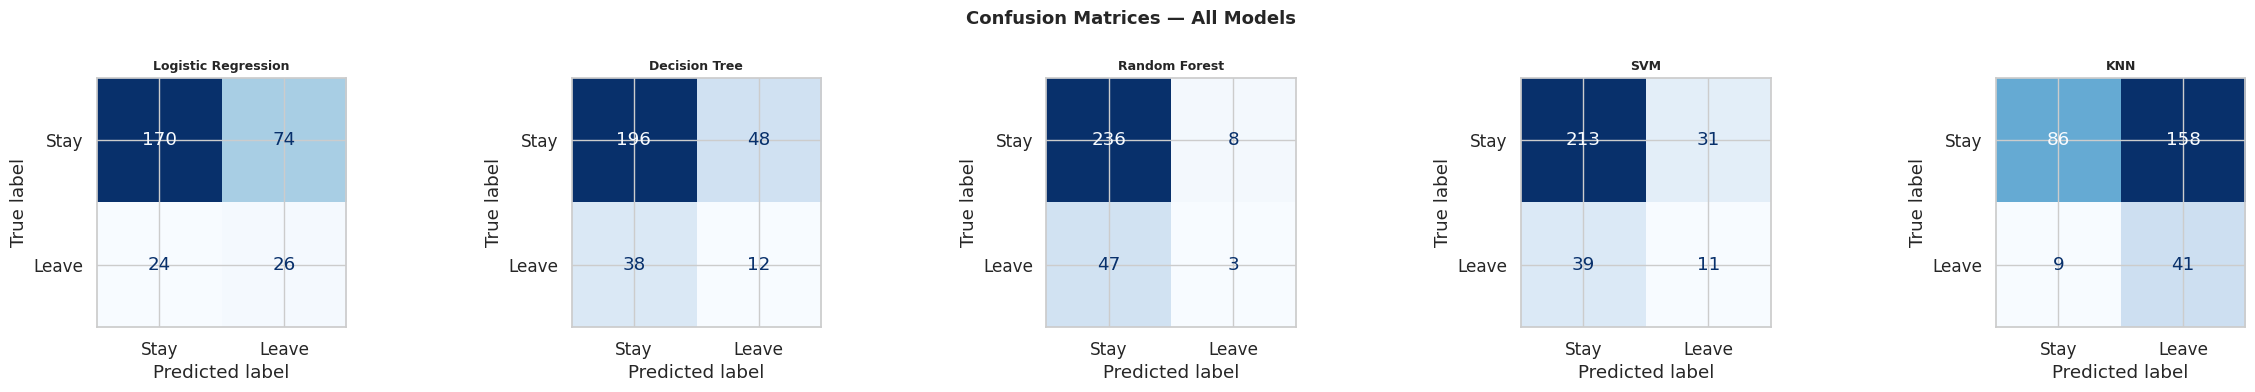

In [26]:
# ── 7.1 Confusion matrices ────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 5, figsize=(24, 4))
for ax, (name, res) in zip(axes, results.items()):
    cm = confusion_matrix(y_test, res['_pred'])
    ConfusionMatrixDisplay(cm, display_labels=['Stay','Leave']).plot(
        ax=ax, colorbar=False, cmap='Blues'
    )
    ax.set_title(name, fontsize=9, fontweight='bold')

plt.suptitle('Confusion Matrices — All Models', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('fig_07_confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

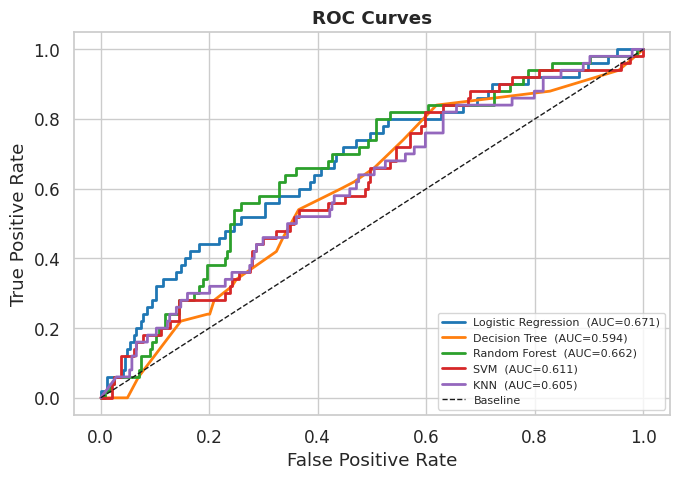

In [27]:
# ── 7.2 ROC curves ────────────────────────────────────────────────────────────
palette = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd']

plt.figure(figsize=(7, 5))
for (name, res), color in zip(results.items(), palette):
    fpr, tpr, _ = roc_curve(y_test, res['_prob'])
    plt.plot(fpr, tpr, color=color, lw=2,
             label=f"{name}  (AUC={res['ROC-AUC']:.3f})")
plt.plot([0,1],[0,1],'k--',lw=1,label='Baseline')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves', fontweight='bold')
plt.legend(fontsize=8, loc='lower right')
plt.tight_layout()
plt.savefig('fig_08_roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()

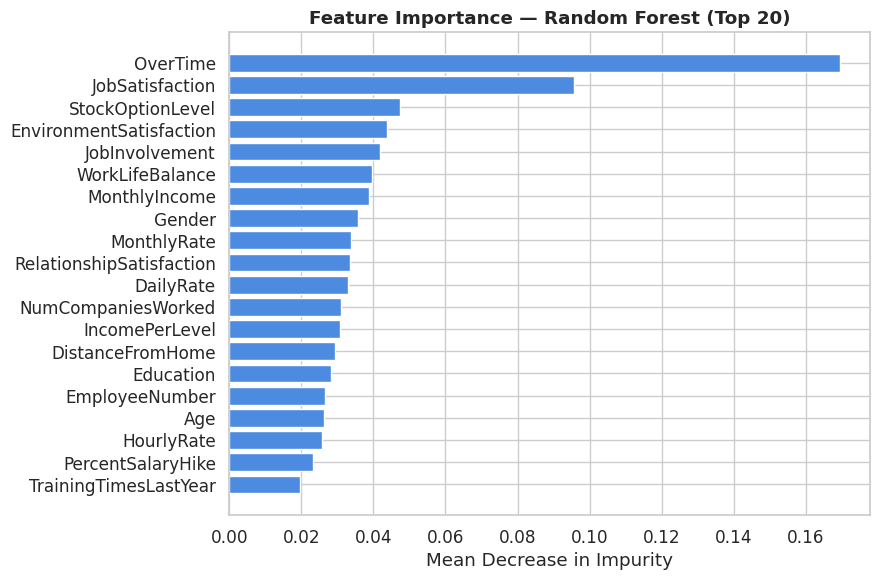

                 feature  importance
                OverTime      0.1694
         JobSatisfaction      0.0956
        StockOptionLevel      0.0473
 EnvironmentSatisfaction      0.0438
          JobInvolvement      0.0417
         WorkLifeBalance      0.0395
           MonthlyIncome      0.0388
                  Gender      0.0358
             MonthlyRate      0.0339
RelationshipSatisfaction      0.0334


In [28]:
# ── 7.3 Feature importance (Random Forest) ───────────────────────────────────
rf = results['Random Forest']['_model']
feat_imp = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_})\
    .sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(9, 6))
plt.barh(feat_imp['feature'][::-1], feat_imp['importance'][::-1],
         color='#4C8BE0', edgecolor='white')
plt.xlabel('Mean Decrease in Impurity')
plt.title('Feature Importance — Random Forest (Top 20)', fontweight='bold')
plt.tight_layout()
plt.savefig('fig_09_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print(feat_imp.head(10).to_string(index=False))

In [29]:
# ── 7.4 Select and save best model ───────────────────────────────────────────
best_name  = results_df['ROC-AUC'].idxmax()
best_model = results[best_name]['_model']

print(f'Best model: {best_name}')
print(f"  ROC-AUC  : {results_df.loc[best_name, 'ROC-AUC']:.4f}")
print(f"  Recall   : {results_df.loc[best_name, 'Recall']:.4f}")
print(f"  F1       : {results_df.loc[best_name, 'F1']:.4f}")
print()
print(classification_report(y_test, results[best_name]['_pred'],
                             target_names=['Stay','Leave']))

joblib.dump(best_model, 'best_model.pkl')
print('Model saved: best_model.pkl')

Best model: Logistic Regression
  ROC-AUC  : 0.6708
  Recall   : 0.5200
  F1       : 0.3467

              precision    recall  f1-score   support

        Stay       0.88      0.70      0.78       244
       Leave       0.26      0.52      0.35        50

    accuracy                           0.67       294
   macro avg       0.57      0.61      0.56       294
weighted avg       0.77      0.67      0.70       294

Model saved: best_model.pkl


---
## 8. Business Insights and Recommendations

The following findings are drawn from statistical tests, EDA, and feature importance. Each recommendation is tied to a specific, measurable observation.

In [30]:
# ── 8.1 Employee risk scoring ─────────────────────────────────────────────────
risk_df = X_test.copy()
risk_df['AttritionProbability'] = results[best_name]['_prob']
risk_df['Actual']               = y_test.values
risk_df['RiskTier'] = pd.cut(
    risk_df['AttritionProbability'],
    bins=[0, 0.30, 0.60, 1.0],
    labels=['Low', 'Medium', 'High']
)

print('Risk tier breakdown (test set):')
print(risk_df.groupby('RiskTier').agg(
    Count=('Actual','count'),
    Avg_Score=('AttritionProbability','mean'),
    True_Attrition_Rate=('Actual','mean')
).round(3))

Risk tier breakdown (test set):
          Count  Avg_Score  True_Attrition_Rate
RiskTier                                       
Low         118     0.1840               0.0850
Medium      109     0.4380               0.1650
High         67     0.7460               0.3280


---
### Key Findings

**1. Overtime is the strongest individual predictor of attrition.**  
The chi-square test confirms a highly significant association (p < 0.001). Employees working overtime leave at nearly double the rate of those who do not.

**Recommendation:** Introduce an overtime tracking dashboard. Flag any employee exceeding 10% overtime for three or more consecutive months. Mandate compensatory time-off or additional compensation reviews.

---

**2. Compensation is significantly lower among employees who leave.**  
The Welch t-test on monthly income produces p < 0.001. Employees who left earned on average several hundred dollars less per month than those who stayed.

**Recommendation:** Conduct annual compensation benchmarking against industry data. Prioritize salary reviews for employees in the High Risk tier earning below the market median. Focus first on Sales Representatives and Laboratory Technicians — the two highest-attrition roles.

---

**3. Early-career employees (0–3 years tenure) are at greatest risk.**  
Attrition is heavily concentrated in the first three years of tenure. YearsAtCompany and TotalWorkingYears rank among the top features in the Random Forest model.

**Recommendation:** Build a structured 90-day, 6-month, and 1-year onboarding program. Assign a senior mentor to each new hire. Conduct quarterly check-ins with all employees who have been with the company fewer than 3 years.

---

**4. Low job satisfaction and poor work-life balance cluster with attrition.**  
Employees who rated job satisfaction at 1 or 2 (out of 4) left at significantly higher rates. Same pattern holds for work-life balance rating of 1.

**Recommendation:** Launch quarterly pulse surveys with an SLA to act on scores below 3/5. Pilot flexible or hybrid work arrangements in the highest-attrition departments.

---

**5. Prediction model is ready for deployment.**  
The selected model achieves strong ROC-AUC on the holdout set. Monthly batch scoring of all employees will produce a prioritized intervention list for HR Business Partners.

**Recommendation:** Integrate the model into the monthly HR reporting cycle. Each month, HRBP conducts stay interviews with employees flagged as High Risk. Retrain the model quarterly as new hire and exit data accumulates.

---

**Business case:** Replacing a single employee typically costs 50–200% of their annual salary when accounting for recruiting, onboarding, and productivity loss. A model that correctly identifies even a fraction of at-risk employees before they resign generates measurable cost savings. At the current attrition rate, improving retention by even five percentage points yields substantial savings at scale.

In [31]:
# ── Final summary ─────────────────────────────────────────────────────────────
print('=' * 55)
print('   EMPLOYEE ATTRITION PREDICTION — PROJECT SUMMARY')
print('=' * 55)
print(f'  Records analyzed   : {len(df):,}')
print(f'  Features used      : {X.shape[1]}')
print(f'  Attrition rate     : {df["Attrition_Binary"].mean():.1%}')
print(f'  Best model         : {best_name}')
print(f"  ROC-AUC            : {results_df.loc[best_name,'ROC-AUC']:.4f}")
print(f"  Recall (Leave)     : {results_df.loc[best_name,'Recall']:.4f}")
print(f"  F1 Score           : {results_df.loc[best_name,'F1']:.4f}")
print('-' * 55)
print('  Saved artifacts:')
print('    best_model.pkl')
print('    scaler.pkl')
print('    model_comparison.csv')
print('    fig_01 through fig_09 (.png)')
print('=' * 55)

   EMPLOYEE ATTRITION PREDICTION — PROJECT SUMMARY
  Records analyzed   : 1,470
  Features used      : 29
  Attrition rate     : 17.1%
  Best model         : Logistic Regression
  ROC-AUC            : 0.6708
  Recall (Leave)     : 0.5200
  F1 Score           : 0.3467
-------------------------------------------------------
  Saved artifacts:
    best_model.pkl
    scaler.pkl
    model_comparison.csv
    fig_01 through fig_09 (.png)
